In [28]:
# Let's do our imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import os
import warnings
import urllib.request
import zipfile
from scipy.stats import randint, uniform
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from xgboost import XGBRegressor
from glob import glob
%matplotlib inline

In [4]:
# Let's get our data. We'll try the method from the lecture
# Commented mostly, as the folders are already present

# url="https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip"
# fname = "caterpillar-tube-pricing.zip"

# urllib.request.urlretrieve(url, fname)

# with zipfile.ZipFile(fname, 'r') as zip_ref:
#     zip_ref.extractall('.')

# with zipfile.ZipFile("data.zip", 'r') as zip_ref:
#     zip_ref.extractall('.')

data = {}
for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    bname = os.path.basename(path)
    name = os.path.splitext(bname)[0]
    data[name] = df

data['bill_of_materials'].head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# The way that Alex melted this dataframe to get a tidy listing was excellent
SOURCE = 'competition_data'
billmats = pd.read_csv(SOURCE + '/bill_of_materials.csv')
assembly_comps = billmats.melt(id_vars='tube_assembly_id',
                               value_vars=[f'component_id_{n}' for n in range(1,9)])

assembly_comps = (assembly_comps
                  .sort_values(by='tube_assembly_id')
                  .dropna()
                  .rename(columns={'value': 'component_id'}))

assembly_comps.head(10)

,tube_assembly_id,variable,component_id
0,TA-00001,component_id_1,C-1622
21198,TA-00001,component_id_2,C-1629
1,TA-00002,component_id_1,C-1312
2,TA-00003,component_id_1,C-1312
3,TA-00004,component_id_1,C-1312
4,TA-00005,component_id_1,C-1624
42400,TA-00005,component_id_3,C-1641
21202,TA-00005,component_id_2,C-1631
5,TA-00006,component_id_1,C-1624
21203,TA-00006,component_id_2,C-1631


In [7]:
# However, for the purposes of this assignment, we won't be taking advantage of it
# We used the bill_of_materials, components, and tube csv's to set up our pipeline

data['components'].head()

,component_id,name,component_type_id
0,9999,OTHER,OTHER
1,C-0001,SLEEVE,CP-024
2,C-0002,SLEEVE,CP-024
3,C-0003,SLEEVE-FLARED,CP-024
4,C-0004,NUT,CP-026


In [8]:
data['components'].describe()

,component_id,name,component_type_id
count,2048,2047,2048
unique,2048,297,29
top,C-1774,FLANGE,OTHER
freq,1,350,1006


In [14]:
# Now let's get the components csv so we can merge that
components = pd.read_csv(SOURCE + '/components.csv')
components = components.rename(columns={'component_id': 'component_id_1'})
compfeats = ['component_id_1', 'component_type_id']

In [9]:
data['bill_of_materials'].head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data['bill_of_materials'].describe()

,quantity_1,quantity_2,quantity_3,quantity_4,quantity_5,quantity_6,quantity_7,quantity_8
count,19149.000000,14786.000000,4798.000000,608.000000,92.000000,26.000000,7.0,1.0
mean,1.559873,1.526106,1.020634,1.027961,1.032609,1.153846,1.0,1.0
std,0.507444,0.510851,0.160100,0.209041,0.178583,0.367946,0.0,NaN
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
50%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
75%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
max,6.000000,6.000000,4.000000,4.000000,2.000000,2.000000,1.0,1.0


In [15]:
# Now let's get the bill of materials csv, engineer features, then merge
billmat = pd.read_csv(SOURCE + '/bill_of_materials.csv')

# We'll separate the numeric and non numeric columns
numcols = billmat.select_dtypes(include='number').columns.tolist()
objcols = billmat.select_dtypes(exclude='number').columns.tolist()    

# and we'll take care of the null values for numeric columns, and engineer a new feature, total components
billmat[numcols] = billmat[numcols].fillna(0)
billmat['comps_total'] = billmat[numcols].sum(axis=1)

# Now let's work with the non numeric columns, so that we can engineer new feature distinct components
obj = billmat[objcols].drop(['tube_assembly_id'], axis=1)
obj = obj.notnull().astype(int)

billmat['comps_dist'] = obj.sum(axis=1)

# Now let's choose the features we want to merge for billmat
matfeats = ['tube_assembly_id', 'component_id_1', 'comps_total', 'comps_dist']

In [11]:
data['tube'].head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00001,SP-0035,12.70,1.65,164.0,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0
1,TA-00002,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00003,SP-0019,6.35,0.71,127.0,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00005,SP-0029,19.05,1.24,109.0,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0


In [12]:
data['tube'].describe()

,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other
count,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000
mean,23.687764,1.578402,100.312844,3.748137,49.350767,0.044485,0.006746,0.022644
std,25.396277,0.745749,70.542771,2.265405,196.468480,0.260737,0.100015,0.199676
min,3.180000,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.520000,0.890000,48.000000,2.000000,19.050000,0.000000,0.000000,0.000000
50%,15.880000,1.650000,86.000000,3.000000,38.100000,0.000000,0.000000,0.000000
75%,25.400000,1.650000,135.000000,5.000000,50.800000,0.000000,0.000000,0.000000
max,203.200000,7.900000,1333.000000,17.000000,9999.000000,5.000000,5.000000,8.000000


In [16]:
# Let's get the tube dataframe
tube = pd.read_csv(SOURCE + '/tube.csv')
# What features do we want to merge from tube
tubefeats = ['tube_assembly_id', 'diameter', 'wall', 'length', 'num_bends', 'bend_radius']

In [17]:
# Now let's import train and test csv's
trainval = pd.read_csv(SOURCE + '/train_set.csv')
test = pd.read_csv(SOURCE + '/test_set.csv')

# So we're going to split on tube_assembly_id
trainval_assemblies = trainval['tube_assembly_id'].unique()
train_assemblies, val_assemblies = train_test_split(trainval_assemblies, random_state=42)
# Now we use our arrays of assemblies to split our dataframe
train = trainval[trainval['tube_assembly_id'].isin(train_assemblies)]
val = trainval[trainval['tube_assembly_id'].isin(val_assemblies)]


# And now we can do our feature engineering to set up our model
# I tried to clean up the code a little bit, as per the assignment

def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))


def organize(X):
    X = X.copy()
    
    # We'll create a list for duplicate and meaningless columns
    duplicates =[]
    meaningless = []
    
    # Let's pull month and year out of quote date
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    
    # now let's merge over
    X = (X.merge(tube[tubefeats], how='left')
        .merge(billmat[matfeats], how='left')
        .merge(components[compfeats], how='left'))

    
    # Now we can add quote_date & tube_assembly_id
    meaningless = meaningless + ['quote_date', 'tube_assembly_id']
    
    todrop = duplicates + meaningless
    X = X.drop(columns=todrop)
    
    return X


# Now we organize train, val and test
train = organize(train)
val = organize(val)
test = organize(test)

In [18]:
# Now let's Arrange x matrix and y vector
target = 'cost'
xtrain = train.drop(columns=target)
xval = val.drop(columns=target)
xtest = test.drop(columns='id')

ytrain = train[target]
yval = val[target]

ytrainlog = np.log1p(ytrain)
yvallog = np.log1p(yval)

In [19]:
xtrain.head()

,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,quote_date_year,quote_date_month,diameter,wall,length,num_bends,bend_radius,component_id_1,comps_total,comps_dist,component_type_id
0,S-0066,0,0,Yes,1,2013,7,6.35,0.71,137.0,9,19.05,C-1312,2.0,1,CP-028
1,S-0066,0,0,Yes,2,2013,7,6.35,0.71,137.0,9,19.05,C-1312,2.0,1,CP-028
2,S-0066,0,0,Yes,5,2013,7,6.35,0.71,137.0,9,19.05,C-1312,2.0,1,CP-028
3,S-0066,0,0,Yes,10,2013,7,6.35,0.71,137.0,9,19.05,C-1312,2.0,1,CP-028
4,S-0066,0,0,Yes,25,2013,7,6.35,0.71,137.0,9,19.05,C-1312,2.0,1,CP-028


In [20]:
xtrain.shape

(22628, 16)

In [21]:
# Now let's use XGBoost to fit and evaluate
warnings.simplefilter(action='ignore', category=FutureWarning)


encoder = ce.OrdinalEncoder()
xtrainencoded = encoder.fit_transform(xtrain)
xvalencoded = encoder.transform(xval)
eval_set = [(xtrainencoded, ytrainlog), 
            (xvalencoded, yvallog)]

model = XGBRegressor(n_estimators=2000, n_jobs=-1)
model.fit(xtrainencoded, ytrainlog, 
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)

[23:59:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.71924	validation_1-rmse:1.70846
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.56516	validation_1-rmse:1.55498
[2]	validation_0-rmse:1.42779	validation_1-rmse:1.41846
[3]	validation_0-rmse:1.30338	validation_1-rmse:1.2943
[4]	validation_0-rmse:1.19168	validation_1-rmse:1.18295
[5]	validation_0-rmse:1.09322	validation_1-rmse:1.08553
[6]	validation_0-rmse:1.0052	validation_1-rmse:0.997831
[7]	validation_0-rmse:0.927626	validation_1-rmse:0.922043
[8]	validation_0-rmse:0.859917	validation_1-rmse:0.857039
[9]	validation_0-rmse:0.799932	validation_1-rmse:0.798449
[10]	validation_0-rmse:0.747477	validation_1-rmse:0.747753
[11]	validation_0-rmse:0.700333	validation_1-rmse:0.700603
[12]	validation_0-rmse:0.660555	validation

[135]	validation_0-rmse:0.298446	validation_1-rmse:0.323511
[136]	validation_0-rmse:0.298162	validation_1-rmse:0.323412
[137]	validation_0-rmse:0.297761	validation_1-rmse:0.323054
[138]	validation_0-rmse:0.297145	validation_1-rmse:0.322351
[139]	validation_0-rmse:0.296826	validation_1-rmse:0.322082
[140]	validation_0-rmse:0.2966	validation_1-rmse:0.321975
[141]	validation_0-rmse:0.296353	validation_1-rmse:0.321917
[142]	validation_0-rmse:0.29606	validation_1-rmse:0.321731
[143]	validation_0-rmse:0.295711	validation_1-rmse:0.321464
[144]	validation_0-rmse:0.295444	validation_1-rmse:0.321307
[145]	validation_0-rmse:0.294936	validation_1-rmse:0.320823
[146]	validation_0-rmse:0.294582	validation_1-rmse:0.32057
[147]	validation_0-rmse:0.293924	validation_1-rmse:0.320156
[148]	validation_0-rmse:0.293596	validation_1-rmse:0.320171
[149]	validation_0-rmse:0.29335	validation_1-rmse:0.319753
[150]	validation_0-rmse:0.292959	validation_1-rmse:0.319387
[151]	validation_0-rmse:0.292525	validation_1

[272]	validation_0-rmse:0.266167	validation_1-rmse:0.30026
[273]	validation_0-rmse:0.265977	validation_1-rmse:0.30024
[274]	validation_0-rmse:0.265813	validation_1-rmse:0.30017
[275]	validation_0-rmse:0.265765	validation_1-rmse:0.300204
[276]	validation_0-rmse:0.265654	validation_1-rmse:0.300202
[277]	validation_0-rmse:0.265632	validation_1-rmse:0.300181
[278]	validation_0-rmse:0.265581	validation_1-rmse:0.300125
[279]	validation_0-rmse:0.265484	validation_1-rmse:0.300055
[280]	validation_0-rmse:0.265359	validation_1-rmse:0.299839
[281]	validation_0-rmse:0.265267	validation_1-rmse:0.299857
[282]	validation_0-rmse:0.265163	validation_1-rmse:0.29985
[283]	validation_0-rmse:0.264835	validation_1-rmse:0.29897
[284]	validation_0-rmse:0.26467	validation_1-rmse:0.298884
[285]	validation_0-rmse:0.264656	validation_1-rmse:0.298873
[286]	validation_0-rmse:0.264553	validation_1-rmse:0.298784
[287]	validation_0-rmse:0.264507	validation_1-rmse:0.298688
[288]	validation_0-rmse:0.264415	validation_1-

[410]	validation_0-rmse:0.248927	validation_1-rmse:0.288575
[411]	validation_0-rmse:0.248826	validation_1-rmse:0.28855
[412]	validation_0-rmse:0.248754	validation_1-rmse:0.288427
[413]	validation_0-rmse:0.24856	validation_1-rmse:0.28817
[414]	validation_0-rmse:0.248435	validation_1-rmse:0.288206
[415]	validation_0-rmse:0.248361	validation_1-rmse:0.288159
[416]	validation_0-rmse:0.248245	validation_1-rmse:0.288144
[417]	validation_0-rmse:0.248139	validation_1-rmse:0.288127
[418]	validation_0-rmse:0.247983	validation_1-rmse:0.288088
[419]	validation_0-rmse:0.247933	validation_1-rmse:0.288076
[420]	validation_0-rmse:0.247855	validation_1-rmse:0.288016
[421]	validation_0-rmse:0.247755	validation_1-rmse:0.288001
[422]	validation_0-rmse:0.247641	validation_1-rmse:0.287989
[423]	validation_0-rmse:0.247565	validation_1-rmse:0.287946
[424]	validation_0-rmse:0.247535	validation_1-rmse:0.287933
[425]	validation_0-rmse:0.247507	validation_1-rmse:0.287923
[426]	validation_0-rmse:0.247402	validation

[548]	validation_0-rmse:0.237557	validation_1-rmse:0.283801
[549]	validation_0-rmse:0.237387	validation_1-rmse:0.283568
[550]	validation_0-rmse:0.237215	validation_1-rmse:0.283385
[551]	validation_0-rmse:0.237131	validation_1-rmse:0.283305
[552]	validation_0-rmse:0.237013	validation_1-rmse:0.283201
[553]	validation_0-rmse:0.236935	validation_1-rmse:0.283266
[554]	validation_0-rmse:0.23684	validation_1-rmse:0.28315
[555]	validation_0-rmse:0.236758	validation_1-rmse:0.2831
[556]	validation_0-rmse:0.236652	validation_1-rmse:0.283105
[557]	validation_0-rmse:0.236499	validation_1-rmse:0.28293
[558]	validation_0-rmse:0.236367	validation_1-rmse:0.282847
[559]	validation_0-rmse:0.236302	validation_1-rmse:0.282889
[560]	validation_0-rmse:0.236272	validation_1-rmse:0.282892
[561]	validation_0-rmse:0.236187	validation_1-rmse:0.282906
[562]	validation_0-rmse:0.236163	validation_1-rmse:0.282922
[563]	validation_0-rmse:0.236146	validation_1-rmse:0.282908
[564]	validation_0-rmse:0.236081	validation_1

[686]	validation_0-rmse:0.227218	validation_1-rmse:0.279474
[687]	validation_0-rmse:0.227142	validation_1-rmse:0.279473
[688]	validation_0-rmse:0.227108	validation_1-rmse:0.279408
[689]	validation_0-rmse:0.227078	validation_1-rmse:0.279364
[690]	validation_0-rmse:0.226988	validation_1-rmse:0.279296
[691]	validation_0-rmse:0.226941	validation_1-rmse:0.279205
[692]	validation_0-rmse:0.226876	validation_1-rmse:0.279249
[693]	validation_0-rmse:0.226862	validation_1-rmse:0.279266
[694]	validation_0-rmse:0.226809	validation_1-rmse:0.279338
[695]	validation_0-rmse:0.226774	validation_1-rmse:0.27937
[696]	validation_0-rmse:0.226729	validation_1-rmse:0.2794
[697]	validation_0-rmse:0.226638	validation_1-rmse:0.279436
[698]	validation_0-rmse:0.226564	validation_1-rmse:0.279554
[699]	validation_0-rmse:0.2265	validation_1-rmse:0.279641
[700]	validation_0-rmse:0.226398	validation_1-rmse:0.279618
[701]	validation_0-rmse:0.226334	validation_1-rmse:0.279664
[702]	validation_0-rmse:0.22626	validation_1-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

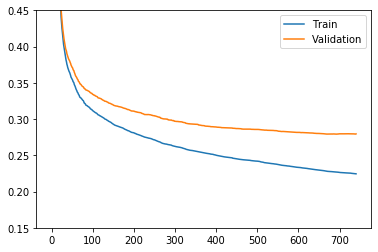

In [25]:
results = model.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
epoch = range(len(train_rmse))
plt.plot(epoch, train_rmse, label='Train')
plt.plot(epoch, val_rmse, label='Validation')
plt.ylim(0.15,0.45)
plt.legend()

In [44]:
# We'll define our kaggle submission generator here
def generate_submission(estimator, xtest, filename):
    ypredlog = estimator.predict(xtest)
    # Convert from log-dollars to dollars
    ypred = np.expm1(ypredlog)  
    
    submission = pd.read_csv('sample_submission.csv')
    submission['cost'] = ypred
    submission.to_csv(filename, index=False)
    
xtestencoded = encoder.transform(xtest)

In [34]:
# Now let's use XGBoost in our pipeline and do some hyperparameter optimization
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(random_state=42)
)

param_distributions = {
    'xgbregressor__n_estimators': randint(500, 1000), 
    'xgbregressor__max_depth': randint(3, 9)
}    

# groups = train['tube_assembly_id']
    
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(xtrain, ytrainlog);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   40.1s remaining:   40.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   40.9s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   52.9s finished


[00:37:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [35]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 665}
Cross-validation RMSLE 0.3364605399305415


In [36]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,8.297252,0.149059,0.475142,0.057335,4,665,"{'xgbregressor__max_depth': 4, 'xgbregressor__...",-0.101228,-0.125183,-0.113206,0.011978,1,-0.023407,-0.016353,-0.019880,0.003527
3,8.634634,0.137130,0.460772,0.017444,4,749,"{'xgbregressor__max_depth': 4, 'xgbregressor__...",-0.101255,-0.125459,-0.113357,0.012102,2,-0.021374,-0.014287,-0.017831,0.003543
4,10.147048,0.237014,1.138151,0.036541,7,723,"{'xgbregressor__max_depth': 7, 'xgbregressor__...",-0.097168,-0.135518,-0.116343,0.019175,3,-0.001504,-0.000603,-0.001053,0.000450
2,17.515365,0.140495,1.796285,0.111009,7,836,"{'xgbregressor__max_depth': 7, 'xgbregressor__...",-0.097198,-0.135557,-0.116378,0.019179,4,-0.001121,-0.000422,-0.000771,0.000350
1,14.996193,0.179121,1.206227,0.190594,8,597,"{'xgbregressor__max_depth': 8, 'xgbregressor__...",-0.103635,-0.141805,-0.122720,0.019085,5,-0.000721,-0.000254,-0.000488,0.000233


In [45]:
pipeline = search.best_estimator_
    
generate_submission(pipeline, xtest, 'opt01submission.csv')